In [1]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
import sacc
import sys
sys.path.insert(0, '/global/u1/z/zhzhuoqi/tjpcov/TJPCov')
from tjpcov import wigner_transform, bin_cov, parse
d2r=np.pi/180

#### Generate NK and GK redshift distribution according to SRD data

In [2]:
def i_to_zmin(i):
    return i*0.1+0.2

def gaussian(x, mu, sigma):
    norm = 1./(sigma*np.sqrt(2*np.pi))
    exp = np.exp(-0.5*((x-mu)/sigma)**2)
    return norm*exp

def gfilter(x_array,y0_array,sigma):
    y_array = 0*x_array
    for x,y,std in zip(x_array,y0_array,sigma):
        y_array += y*gaussian(x_array, x, std)
    return y_array

def get_ndist(zmin, zmax,nbins=100):
    #set up
    diff = zmax - zmin
    z0, alpha = 0.24, 0.90

    #get number density
    N = 48
    z_array = np.linspace(0.0, 8.0, 8001)
    zn_array = z_array*z_array*np.exp(-(z_array/z0)**alpha)
    cut = (zmin<=z_array)*(z_array<=zmax)
    z = z_array[cut]
    zn = zn_array[cut]
    frac = sum(zn)/sum(zn_array)

    #get distribution
    z_array = np.linspace(zmin,zmax,nbins)
    zn = z_array*z_array*np.exp(-(z_array/z0)**alpha)
    zn = np.concatenate((np.zeros(4*nbins), zn, np.zeros(4*nbins)))
    z = np.linspace(zmin-4*diff, zmax+4*diff, int(9*nbins))
    sigma = 0.03*(1+z)
    dist = gfilter(z,zn,sigma)
    dist *= (nbins/(zmax-zmin))/sum(dist)

    N = 48
    bin_N = N*frac

    cut = (z>=max(0,zmin-2.0))*(z<=zmax+2.0)
    return z[cut], dist[cut], bin_N

def get_gdist(bin_num):
    z0, alpha = 0.11, 0.68
        
    z = np.linspace(0.20, 8.20, 8001)
    zn = z*z*np.exp(-(z/z0)**alpha)
    tot = sum(zn)
    z_ = np.linspace(0.00,8.20,8201)
    zn_ = z_*z_*np.exp(-(z_/z0)**alpha)
    tot_ = sum(zn_)
    
    zn *= 1/sum(zn)
    cdf = np.cumsum(zn)
    bound = []
    for percentage in [0,0.20,0.40,0.60,0.80]:
        i = np.searchsorted(cdf,percentage)
        bound.append(i)
    bound.append(7999)
    cut_low = bound[bin_num]
    cut_high = bound[bin_num+1]
    z_bin = z[cut_low:cut_high]
    zn_bin = zn[cut_low:cut_high]
    
    frac = sum(zn_bin)*tot/(sum(zn)*tot_)
    
    zn_bin *= 1000/sum(zn_bin)
    zmin = z_bin[0]
    zmax = z_bin[-1]
    n = len(z_bin)
    z_bin = np.linspace(zmin-1,zmax+1,n+2000)
    zn_bin = np.concatenate((np.zeros(1000), zn_bin, np.zeros(1000)))
    sigma = 0.05*(1+z_bin)
    dist = gfilter(z_bin,zn_bin,sigma)
    dist *= 1000/sum(dist)
    
    N=27.0
    bin_N = N*frac
    
    cut = z_bin>=0
    return z_bin[cut],dist[cut],bin_N

In [3]:
def get_bias(zmin, zmax):
    cosmo = ccl.Cosmology(Omega_c=0.22, Omega_b=0.0486, Omega_g=0, Omega_k=0,
                              h=0.69, sigma8=0.80, n_s=0.968, Neff=0, m_nu=0.0,
                              w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                              mass_function='tinker')
    z0, zn, _ = get_ndist(zmin,zmax)
    z = np.dot(z0,zn)/np.sum(zn)
    a = 1/(1+z)
    
    bias = ccl.background.growth_factor(cosmo, a)    
    return 0.95/bias

take both samples to be 0.2<z<0.5 roughly (I don't know if it makes sense to use a single bin instead of the whole data vector, but this gives us more freedom with noise and signals)

In [4]:
NK_z, NK_nz, NK_N = get_ndist(0.51,0.71) # these three numbers are z, dndz, Ngal (/arcmin^2)
GK_z, GK_nz, GK_N = get_gdist(1) 
b = get_bias(0.2,0.51)

Text(0.5, 1.0, 'normalized galaxy distribution')

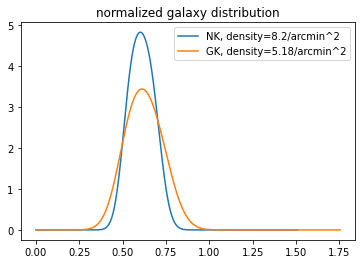

In [5]:
plt.plot(NK_z,NK_nz,label='NK, density='+str(round(NK_N,1))+'/arcmin^2')
plt.plot(GK_z,GK_nz,label='GK, density='+str(round(GK_N,2))+'/arcmin^2')
plt.title('')
plt.legend()
plt.title('normalized galaxy distribution')

#### Set up tracers and cosmology

In [6]:
ells = np.concatenate((
        np.linspace(2, 49, 48),
        np.logspace(np.log10(50), np.log10(6e4), 200)))

In [7]:
#set up cosmology
cosmo_cls = ccl.Cosmology(Omega_c=0.22, Omega_b=0.0486, Omega_g=0, Omega_k=0,
                          h=0.69, sigma8=0.80, n_s=0.968, Neff=0, m_nu=0.0,
                          w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                          mass_function='tinker')
bz = b*np.ones_like(NK_z)

In [8]:
nc_trcr = ccl.NumberCountsTracer(cosmo_cls,has_rsd=False,dndz=(NK_z,NK_nz),bias=(NK_z,bz))
cmb_trcr = ccl.CMBLensingTracer(cosmo_cls,1100.)
wl_trcr = ccl.WeakLensingTracer(cosmo_cls, dndz=(GK_z, GK_nz))

#### calculate correlation functions

Text(0.5, 1.0, 'NK and GK in harmonic space')

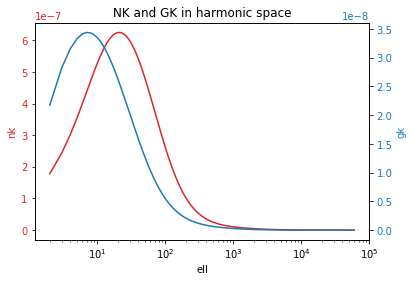

In [9]:
cl_nk = ccl.angular_cl(cosmo_cls,nc_trcr,cmb_trcr,ells)
cl_gk = ccl.angular_cl(cosmo_cls,wl_trcr,cmb_trcr,ells)

#plot
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('ell')
ax1.set_ylabel('nk', color=color)
ax1.plot(ells, cl_nk, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('gk', color=color)  # we already handled the x-label with ax1
ax2.plot(ells, cl_gk, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_title('NK and GK in harmonic space')

In [10]:
theta_deg = np.loadtxt('/global/u1/z/zhzhuoqi/MCMC/map1/all_bins/GK/theta_deg.txt')
# log space from 2.5 to 250 arcmin

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/pyccl/correlation.py:83: CCLWarning: corr_type is deprecated. Use type = NN
  CCLWarning)
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/pyccl/correlation.py:83: CCLWarning: corr_type is deprecated. Use type = NG
  CCLWarning)


Text(0.5, 1.0, 'NK and GK in real space')

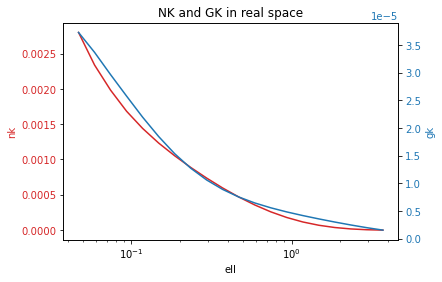

In [11]:
nk = corr = ccl.correlation(cosmo_cls, ells, cl_nk, theta_deg, corr_type='GG', method='FFTLog')
gk = corr = ccl.correlation(cosmo_cls, ells, cl_gk, theta_deg, corr_type='GL', method='FFTLog')

#plot
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('ell')
ax1.set_ylabel('nk', color=color)
ax1.plot(theta_deg, nk, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('gk', color=color)  # we already handled the x-label with ax1
ax2.plot(theta_deg, gk, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax2.set_title('NK and GK in real space')

#### Set up TJPCov

Details see https://github.com/LSSTDESC/TJPCov/blob/master/examples/Gaussian_cov-DES.ipynb

In [12]:
th_min=1/60 # in degrees
th_max=300./60
n_th_bins=20
th_bins=np.logspace(np.log10(2.5/60.),np.log10(250./60.),n_th_bins+1)
th=np.logspace(np.log10(th_min),np.log10(th_max),3000) #covariance is oversampled at th values and then binned.
th2=np.linspace(1,th_max*1.02,3000) #binned covariance can be sensitive to the th values. Make sue you check convergence for your application
th=np.unique(np.sort(np.append(th,th2)))

In [13]:
# Wigner Transform setup... 
WT_kwargs={'l': ells,'theta': th*d2r,'s1_s2':[(0,2),(2,0),(0,0)]}
%time WT=wigner_transform(**WT_kwargs)

CPU times: user 327 ms, sys: 919 ms, total: 1.25 s
Wall time: 14.9 s


In [14]:
fsky = 0.5
norm=np.pi*4*fsky

In [15]:
cl_nn = ccl.angular_cl(cosmo_cls, nc_trcr, nc_trcr, ells)
cl_gg = ccl.angular_cl(cosmo_cls, wl_trcr, wl_trcr, ells)
cl_kk = ccl.angular_cl(cosmo_cls, cmb_trcr, cmb_trcr, ells)
cl_nk = ccl.angular_cl(cosmo_cls,nc_trcr,cmb_trcr,ells)
cl_gk = ccl.angular_cl(cosmo_cls,wl_trcr,cmb_trcr,ells)

In [16]:
def get_nk_cov(cl_nn, cl_nk, cl_kk, shot_noise, cmb_noise):
    coupling = np.eye(len(ells))
    NKcov1 = np.outer(cl_nk, cl_nk)*coupling
    NKcov2 = np.outer(cl_nn+shot_noise, cl_kk+cmb_noise)
    NKcov = NKcov1+NKcov2
    
    theta,cov=WT.projected_covariance2(l_cl=ells,s1_s2=(0,0), s1_s2_cross=(0,0), cl_cov=NKcov)
    thb, cov_binned = bin_cov(r=theta/d2r,r_bins=theta_deg,cov=cov/norm)
    return cov_binned

In [17]:
def get_gk_cov(cl_gg, cl_gk, cl_kk, shape_noise, cmb_noise):
    coupling = np.eye(len(ells))
    GKcov1 = np.outer(cl_gk, cl_gk)*coupling
    GKcov2 = np.outer(cl_gg+shape_noise, cl_kk+cmb_noise)
    GKcov = GKcov1+GKcov2
    
    theta,cov=WT.projected_covariance2(l_cl=ells,s1_s2=(0,2), s1_s2_cross=(0,2), cl_cov=GKcov)
    thb, cov_binned = bin_cov(r=theta/d2r,r_bins=theta_deg,cov=cov/norm)
    return cov_binned

#### CMB noise (SO baseline with a gaussian beam) and other noises

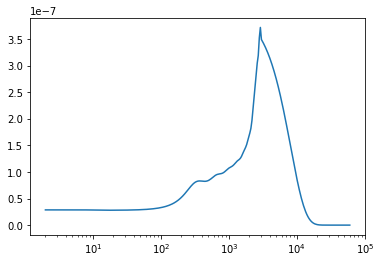

In [18]:
cmb_noise = np.loadtxt('full_noise.txt')
cmb_noise = np.interp(ells, np.arange(len(cmb_noise)), cmb_noise)
plt.plot(ells,cmb_noise)
plt.xscale('log')

In [19]:
shape_noise = 0.26**2/(GK_N*3600/d2r**2)
shot_noise = 1./(NK_N*3600/d2r**2)

#### Calculate GK covariance matrices

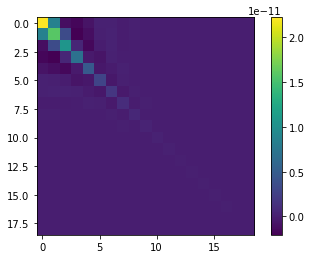

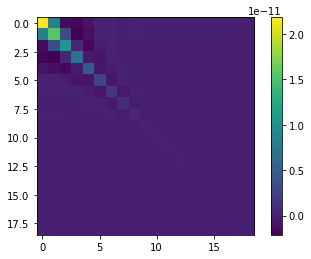

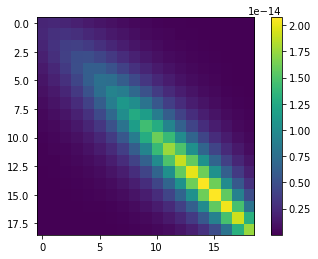

In [20]:
# full covariance
GKcov_full = get_gk_cov(cl_gg, cl_gk, cl_kk, shape_noise, cmb_noise)
plt.imshow(GKcov_full)
plt.colorbar()
plt.show()
GKcov_full = np.diag(GKcov_full)

# noise
GKcov_noise = get_gk_cov(0*cl_gg, 0*cl_gk, 0*cl_kk, shape_noise, cmb_noise)
plt.imshow(GKcov_noise)
plt.colorbar()
plt.show()
GKcov_noise = np.diag(GKcov_noise)

# cosmic variance
GKcov_cv = get_gk_cov(cl_gg, cl_gk, cl_kk, 0*shape_noise, 0*cmb_noise)
plt.imshow(GKcov_cv)
plt.colorbar()
plt.show()
GKcov_cv = np.diag(GKcov_cv)

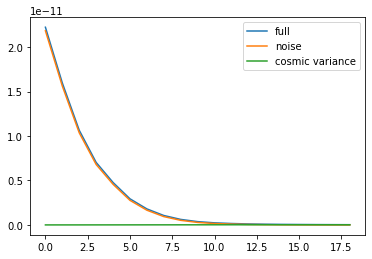

In [21]:
plt.plot(GKcov_full, label='full')
plt.plot(GKcov_noise, label='noise')
plt.plot(GKcov_cv, label='cosmic variance')
plt.legend()

#### What if we reduce the shape noise to 1%?

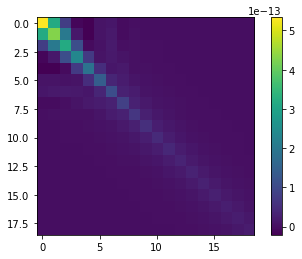

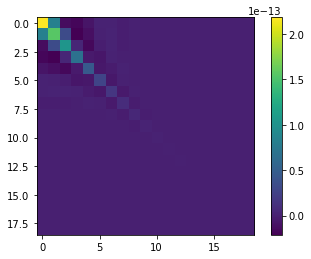

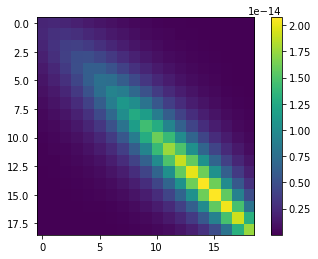

In [22]:
# full covariance
GKcov_full = get_gk_cov(cl_gg, cl_gk, cl_kk, 0.01*shape_noise, cmb_noise)
plt.imshow(GKcov_full)
plt.colorbar()
plt.show()
GKcov_full = np.diag(GKcov_full)

# noise
GKcov_noise = get_gk_cov(0*cl_gg, 0*cl_gk, 0*cl_kk, 0.01*shape_noise, cmb_noise)
plt.imshow(GKcov_noise)
plt.colorbar()
plt.show()
GKcov_noise = np.diag(GKcov_noise)

# cosmic variance
GKcov_cv = get_gk_cov(cl_gg, cl_gk, cl_kk, 0*shape_noise, 0*cmb_noise)
plt.imshow(GKcov_cv)
plt.colorbar()
plt.show()
GKcov_cv = np.diag(GKcov_cv)

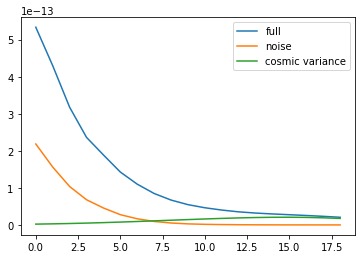

In [23]:
plt.plot(GKcov_full, label='full')
plt.plot(GKcov_noise, label='noise')
plt.plot(GKcov_cv, label='cosmic variance')
plt.legend()

#### Some intuition

(1e-14, 1e-06)

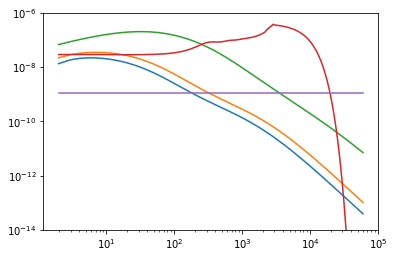

In [24]:
# here are the correlation functions and noises
plt.plot(ells, cl_gg)
plt.plot(ells, cl_gk)
plt.plot(ells, cl_kk)
plt.plot(ells, cmb_noise)
plt.plot(ells, ells*0+shape_noise)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-14, 1e-6)

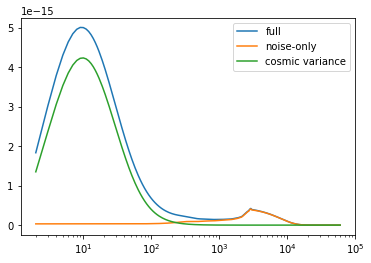

In [25]:
# diagonal of the full cl-covaraince
coupling = np.eye(len(ells))
GKcov1 = np.outer(cl_gk, cl_gk)*coupling
GKcov2 = np.outer(cl_gg+shape_noise, cl_kk+cmb_noise)
GKcov = GKcov1+GKcov2
plt.plot(ells,np.diag(GKcov), label='full')
plt.xscale('log')

# diagonal of the noise-only cl-covariance
coupling = np.eye(len(ells))
GKcov1 = np.outer(0*cl_gk, 0*cl_gk)*coupling
GKcov2 = np.outer(0*cl_gg+shape_noise, 0*cl_kk+cmb_noise)
GKcov = GKcov1+GKcov2
plt.plot(ells,np.diag(GKcov), label='noise-only')

#diagonal of the cl-only cl-covariance
coupling = np.eye(len(ells))
GKcov1 = np.outer(cl_gk, cl_gk)*coupling
GKcov2 = np.outer(cl_gg+0*shape_noise, cl_kk+0*cmb_noise)
GKcov = GKcov1+GKcov2
plt.plot(ells,np.diag(GKcov), label='cosmic variance')
plt.xscale('log')

plt.legend()

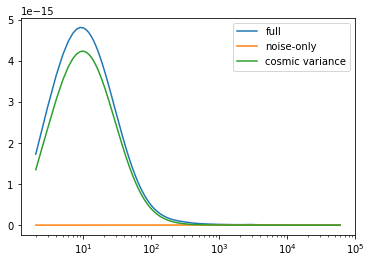

In [26]:
# with 1% of shape noise

# diagonal of the full cl-covaraince
coupling = np.eye(len(ells))
GKcov1 = np.outer(cl_gk, cl_gk)*coupling
GKcov2 = np.outer(cl_gg+0.01*shape_noise, cl_kk+cmb_noise)
GKcov = GKcov1+GKcov2
plt.plot(ells,np.diag(GKcov), label='full')
plt.xscale('log')

# diagonal of the noise-only cl-covariance
coupling = np.eye(len(ells))
GKcov1 = np.outer(0*cl_gk, 0*cl_gk)*coupling
GKcov2 = np.outer(0*cl_gg+0.01*shape_noise, 0*cl_kk+cmb_noise)
GKcov = GKcov1+GKcov2
plt.plot(ells,np.diag(GKcov), label='noise-only')

#diagonal of the cl-only cl-covariance
coupling = np.eye(len(ells))
GKcov1 = np.outer(cl_gk, cl_gk)*coupling
GKcov2 = np.outer(cl_gg+0*shape_noise, cl_kk+0*cmb_noise)
GKcov = GKcov1+GKcov2
plt.plot(ells,np.diag(GKcov), label='cosmic variance')
plt.xscale('log')

plt.legend()

#### Some stuffs with NK, for reference

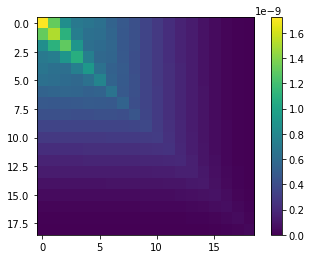

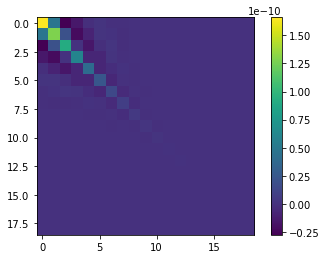

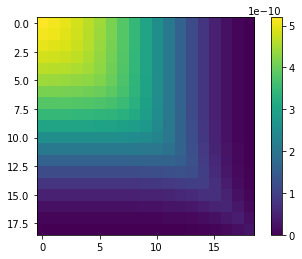

In [27]:
# full covariance
NKcov_full = get_nk_cov(cl_nn, cl_nk, cl_kk, shot_noise, cmb_noise)
plt.imshow(NKcov_full)
plt.colorbar()
plt.show()
NKcov_full = np.diag(NKcov_full)

# noise
NKcov_noise = get_nk_cov(0*cl_nn, 0*cl_nk, 0*cl_kk, shot_noise, cmb_noise)
plt.imshow(NKcov_noise)
plt.colorbar()
plt.show()
NKcov_noise = np.diag(NKcov_noise)

# cosmic variance
NKcov_cv = get_nk_cov(cl_nn, cl_nk, cl_kk, 0*shot_noise, 0*cmb_noise)
plt.imshow(NKcov_cv)
plt.colorbar()
plt.show()
NKcov_cv = np.diag(NKcov_cv)

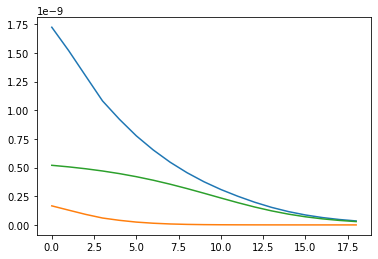

In [28]:
plt.plot(NKcov_full, label='full')
plt.plot(NKcov_noise, label='noise')
plt.plot(NKcov_cv, label='cosmic variace')

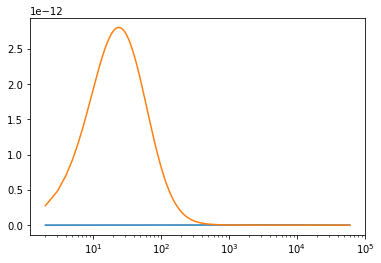

In [29]:
# diagonal of the noise-only cl-covariance
coupling = np.eye(len(ells))
GKcov1 = np.outer(0*cl_nk, 0*cl_nk)*coupling
GKcov2 = np.outer(0*cl_nn+shot_noise, 0*cl_kk+cmb_noise)
GKcov = GKcov1+GKcov2
plt.plot(ells,np.diag(GKcov))

#diagonal of the cl-only cl-covariance
coupling = np.eye(len(ells))
GKcov1 = np.outer(cl_nk, cl_nk)*coupling
GKcov2 = np.outer(cl_nn+0*shot_noise, cl_kk+0*cmb_noise)
GKcov = GKcov1+GKcov2
plt.plot(ells,np.diag(GKcov))
plt.xscale('log')